In [1]:
!pip install coclust
!pip install prince

In [16]:
!pip uninstall coclust 

Uninstalling coclust-0.2.1:
  Would remove:
    /usr/local/bin/coclust
    /usr/local/bin/coclust-nb
    /usr/local/lib/python3.6/dist-packages/coclust-0.2.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/coclust/*
Proceed (y/n)? y
  Successfully uninstalled coclust-0.2.1


In [2]:
from os import listdir 
from os.path import isfile
from os.path import join as jn
from sklearn.feature_extraction.text import TfidfTransformer
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import prince
import seaborn as sns; sns.set()
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from sklearn.metrics.cluster import adjusted_rand_score as ari
from coclust.evaluation.external import accuracy
from coclust.visualization import plot_delta_kl, plot_convergence

import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


### Chargement des données


In [0]:

def files(path):
  # define the path
  listfile = [f for f in listdir(path) if isfile(jn(path, f)) and f.endswith("mat")]
  docTerm_df=dict()
  labels_df=dict()
  for f in listfile:
      print(f)
      X = scipy.io.loadmat(path+f)
      '''X_tfidf = pd.DataFrame(.todense())'''
      if(f=='cstr.mat'):                     
        docTerm_df[f[:-4]]=pd.DataFrame(X['fea'])
        labels_df[f[:-4]]=[x[0]-1 for x in X['gnd']]
      else:
        docTerm_df[f[:-4]]=pd.DataFrame(X['mat'].todense())
        labels_df[f[:-4]]=X['labels'][0]
  return docTerm_df,labels_df 

      
            

In [4]:
docTerm_df,labels_df =files('data/')

rcv4.mat
cstr.mat
classic4.mat


### Visualisation des clusters

In [0]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import prince
import seaborn as sns; sns.set()
colors = sns.color_palette()+sns.color_palette("Paired", 10)+ [(252/255, 186/255, 3/255)]
def plot_CA(X, y, title, ax, with_column=True):
  ca = prince.CA(n_components=2)
  ca.fit(X)
  cols = ca.column_coordinates(X).to_numpy()
  rows = ca.row_coordinates(X).to_numpy()
  if with_column:
    y = np.hstack([np.full(len(cols), "Terms"), y])
    projection = np.vstack([cols, rows])
  else:
    projection = rows

  color_mapping = {c:i for i, c in enumerate(np.unique(y))}
  plt.sca(ax)
  plt.scatter(projection[:, 0], projection[:, 1], c=[colors[color_mapping[c]] for c in y])
  
  plt.legend(handles=[mpatches.Patch(color=colors[color_mapping[k]],
  label=k) for k in color_mapping.keys()])
  plt.title("Correspondence Analysis on " + title)
  plt.xticks([])
  plt.yticks([])

rcv4
cstr
classic4


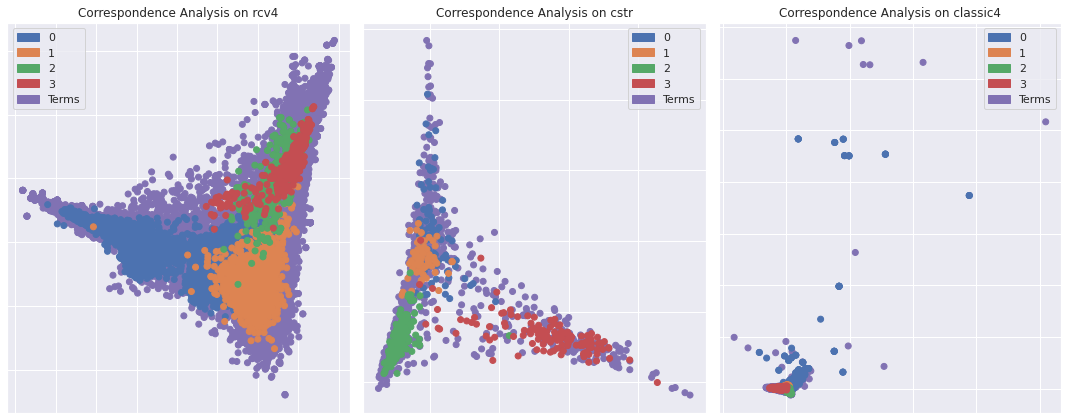

In [0]:
fig, axes = plt.subplots(1, len(docTerm_df.keys()), figsize=(15, 6))
for k, ax in zip(docTerm_df.keys(), axes):
  print(k)
  X = docTerm_df[k]
  y = labels_df[k]
  plot_CA(X, y, k, ax)
plt.tight_layout()


### Generation de différents taux de données manquantes

In [0]:
import collections
import random

def missing_data(df,p):
  replaced = collections.defaultdict(set)
  ix = [(row, col) for row in range(df.shape[0]) for col in range(df.shape[1])]
  random.shuffle(ix)
  to_replace = int(round(p*len(ix)))
  for row, col in ix:
      if len(replaced[row]) < df.shape[1] - 1:
          df.iloc[row, col] = np.nan
          to_replace -= 1
          replaced[row].add(col)
          if to_replace == 0:
              break
  return df

In [0]:
mi_data=dict()
for i in range(1,5):
  p=i*.05
  mi_data=missing_data(docTerm_df['rcv4'], p)
  mi_data.to_csv('missing/rcv4_'+str(round(p*100))+'.csv')





### Coclustering après imputation

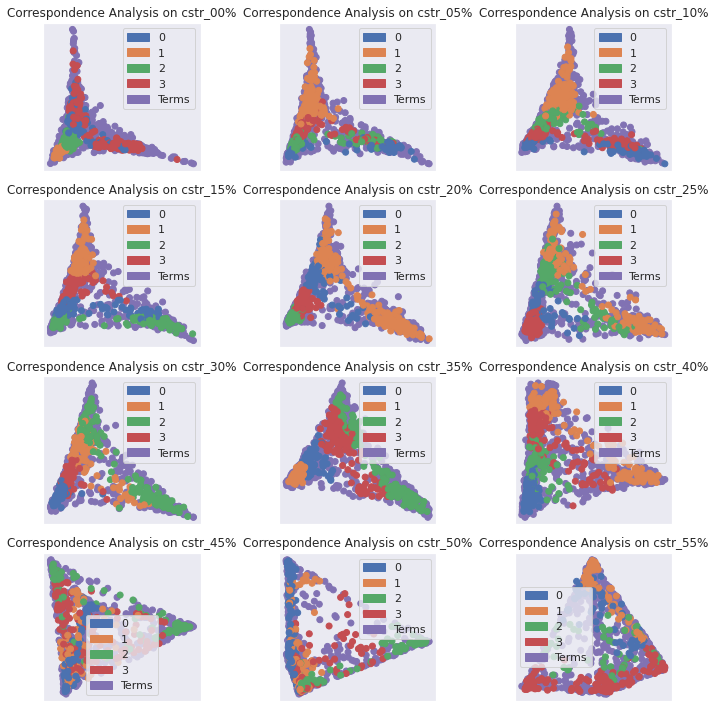

In [0]:
from coclust.coclustering import CoclustInfo

docTerm_df['cstr'].to_csv('impute/impute_cstr_00.csv')
listfile = [f for f in listdir('impute/') if isfile(jn('impute/', f)) and f.endswith("csv")]
listfile.sort()
df_scores=pd.DataFrame(columns=['p','nmi','ari','accuracy'])
fig, axes = plt.subplots(4,3, figsize=(10, 10))
axes = axes.ravel()
for f,ax in zip(listfile,axes):
  X=pd.read_csv('impute/'+f).to_numpy()
  n_clusters=len(np.unique(labels_df['cstr']))
  clusterer = CoclustInfo(n_clusters)
  clusterer.fit(X)
  y_predicted = clusterer.row_labels_
  y=labels_df['cstr']
  nmi=normalized_mutual_info_score(y_predicted,y)
  ari=adjusted_rand_score(y_predicted,y)
  acc=accuracy(y,y_predicted)
  df_scores=df_scores.append({'p': int(f[12:14]),
                              'nmi' : nmi,
                              'ari' : ari,
                              'accuracy': acc} ,
                              ignore_index=True)
  plot_CA(X, y_predicted, f[7:14]+'%', ax)
plt.tight_layout()

  


### Evaluation du clustering sur les données imputées avec AFC itérative par rapport à plusieurs taux de données manquantes

In [0]:
from sklearn.metrics.cluster import normalized_mutual_info_score 
from sklearn.metrics.cluster import adjusted_rand_score 
from coclust.evaluation.external import accuracy
def scores(k,y_predicted,y):  
  print("on :", k)
  print("nmi =",normalized_mutual_info_score(y_predicted,y))
  print("ari =",adjusted_rand_score(y_predicted,y))
  print("accuracy =",accuracy(y,y_predicted))

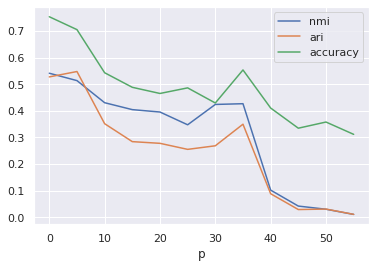

In [0]:
df_scores.plot(x='p',y=['nmi','ari','accuracy'])


### Execution de la variante de Coclust Info sur CSTR avec déffirents taux de données manquantes


In [0]:
X=pd.read_csv('missing/cstr_05.csv')

In [15]:
type(X.to_numpy())

numpy.ndarray

coclust on cstr with 00 % missing data::


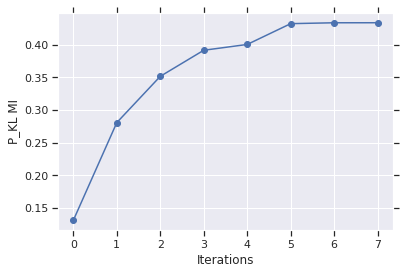

coclust on cstr with 05 % missing data::


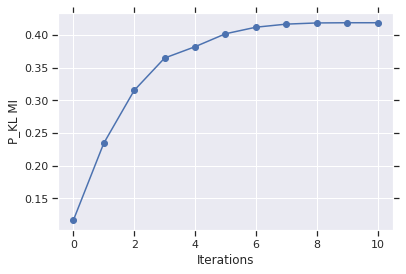

coclust on cstr with 10 % missing data::


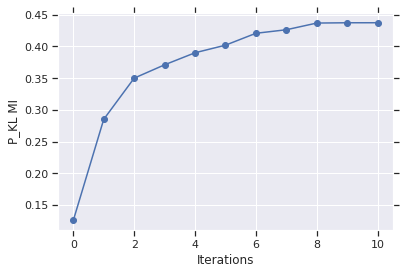

coclust on cstr with 15 % missing data::


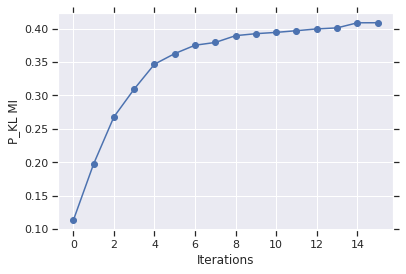

coclust on cstr with 20 % missing data::


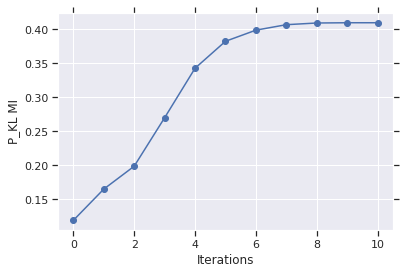

coclust on cstr with 25 % missing data::


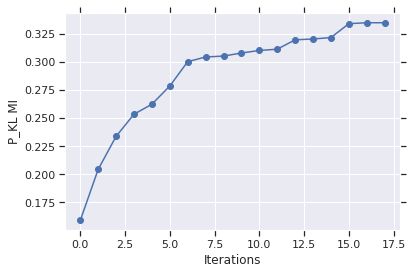

coclust on cstr with 30 % missing data::


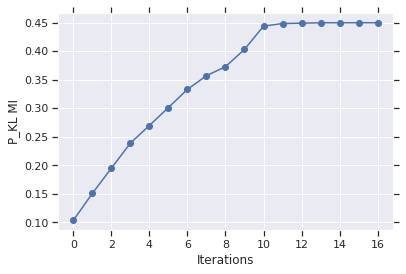

coclust on cstr with 35 % missing data::


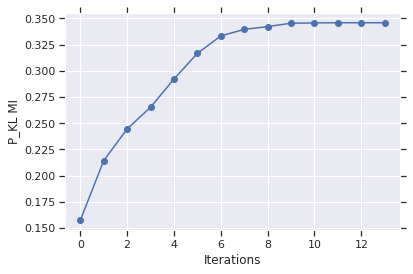

coclust on cstr with 40 % missing data::


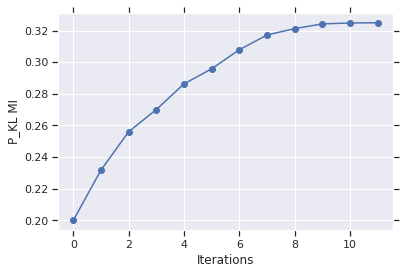

coclust on cstr with 45 % missing data::


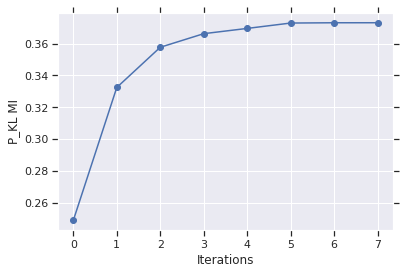

coclust on cstr with 50 % missing data::


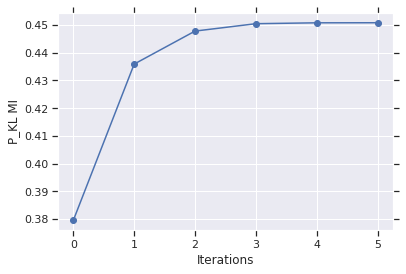

coclust on cstr with 55 % missing data::


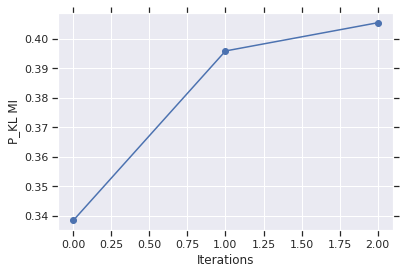

<Figure size 432x288 with 0 Axes>

In [66]:
from sklearn.metrics.cluster import normalized_mutual_info_score 
from sklearn.metrics.cluster import adjusted_rand_score 
from coclust.evaluation.external import accuracy
docTerm_df['cstr'].to_csv('missing/cstr_00.csv')
listfile = [f for f in listdir('missing/') if isfile(jn('missing/', f)) and f.endswith("csv")]
listfile.sort()

df_scores=pd.DataFrame(columns=['p','nmi','ari','accuracy'])
axes = axes.ravel()
for f in listfile:
  X=pd.read_csv('missing/'+f).to_numpy()
  n_clusters=len(np.unique(labels_df['cstr']))
  clusterer = CoclustInfo(n_row_clusters=nb_clusters, n_col_clusters=nb_clusters,
                    n_init=4, random_state=0)
  clusterer.fit(X)
  y_predicted = clusterer.row_labels_
  y=labels_df['cstr']
  nmi=normalized_mutual_info_score(y_predicted,y)
  ari=adjusted_rand_score(y_predicted,y)
  acc=accuracy(y, y_predicted)
  df_scores=df_scores.append({'p': int(f[5:7]),
                              'nmi' : nmi,
                              'ari' : ari,
                              'accuracy': acc} ,
                              ignore_index=True)
  print('coclust on cstr with {} % missing data::'.format(f[5:7]))
  plot_convergence(clusterer.criterions, 'P_KL MI',)
  plt.tight_layout()   


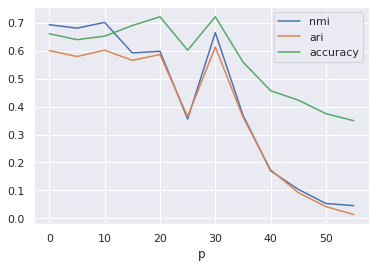

In [67]:
df_scores.plot(x='p',y=['nmi','ari','accuracy'])

CRITERION: 0.4187035061026905
NMI: 0.6811998764638079
ARI: 0.579686942095748
ACCURACY: 0.64


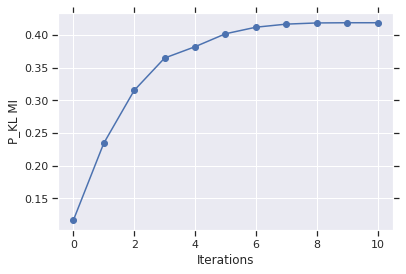

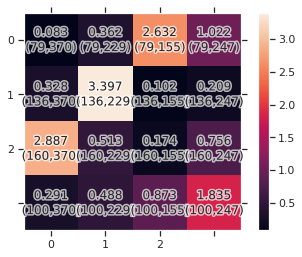

In [43]:
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi 
from sklearn.metrics.cluster import adjusted_rand_score as ari
from coclust.evaluation.external import accuracy
nb_clusters = 4
model = CoclustInfo(n_row_clusters=nb_clusters, n_col_clusters=nb_clusters,
                    n_init=4, random_state=0)
model.fit(X)

# Evaluate the results
print("CRITERION: %s" % model.criterion)
true_row_labels = labels_df['cstr']
predicted_row_labels = model.row_labels_
nmi_ = nmi(true_row_labels, predicted_row_labels)
ari_ = ari(true_row_labels, predicted_row_labels)
print("NMI: {}\nARI: {}".format(nmi_, ari_))
accuracy = accuracy(true_row_labels, predicted_row_labels)
print("ACCURACY: %s" % accuracy)

# Show convergence
plot_convergence(model.criterions, 'P_KL MI')

plot_delta_kl(model)

### CoclustInfo Avec inititialisation en imputation

coclust on cstr with 00 % missing data::


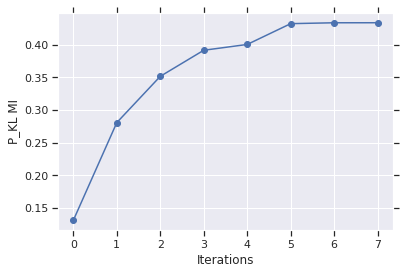

coclust on cstr with 05 % missing data::


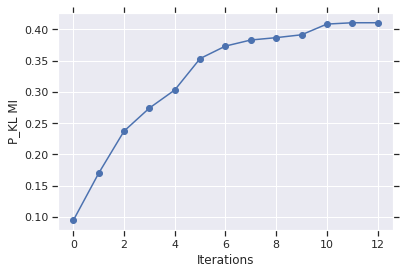

coclust on cstr with 10 % missing data::


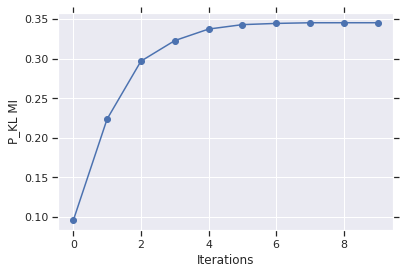

coclust on cstr with 15 % missing data::


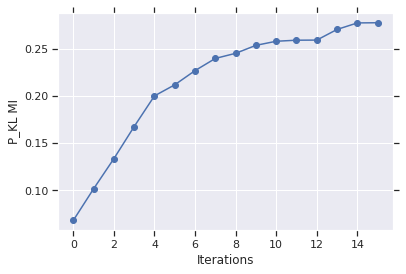

coclust on cstr with 20 % missing data::


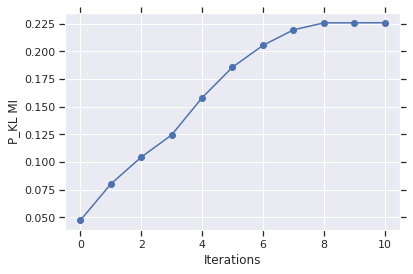

coclust on cstr with 25 % missing data::


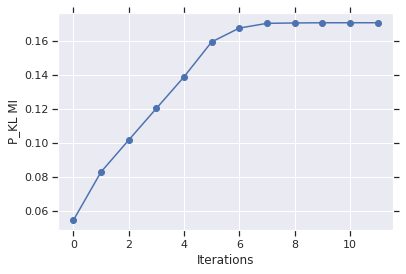

coclust on cstr with 30 % missing data::


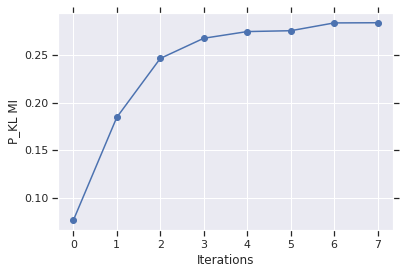

coclust on cstr with 35 % missing data::


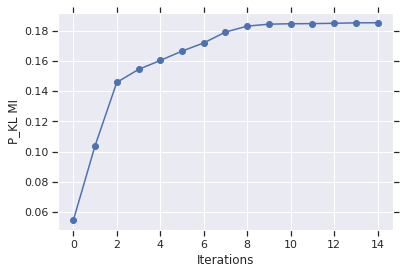

coclust on cstr with 40 % missing data::


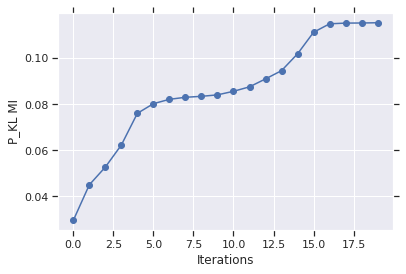

coclust on cstr with 45 % missing data::


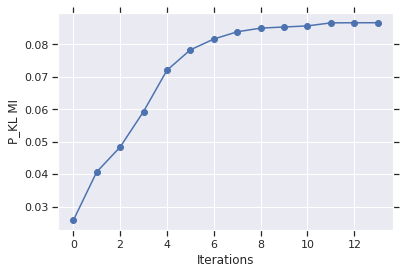

coclust on cstr with 50 % missing data::


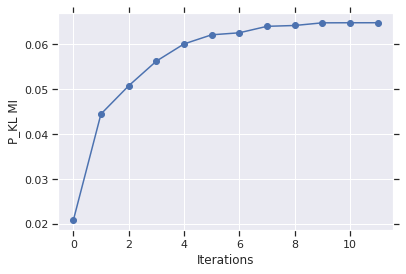

coclust on cstr with 55 % missing data::


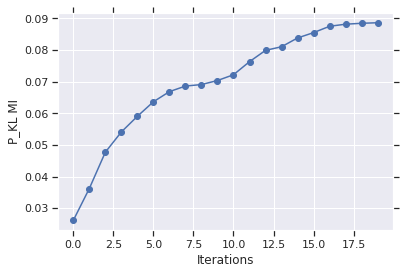

<Figure size 432x288 with 0 Axes>

In [71]:
from sklearn.metrics.cluster import normalized_mutual_info_score 
from sklearn.metrics.cluster import adjusted_rand_score 
from coclust.evaluation.external import accuracy
docTerm_df['cstr'].to_csv('missing/cstr_00.csv')
listfile = [f for f in listdir('missing/') if isfile(jn('missing/', f)) and f.endswith("csv")]
listfile.sort()

df_scores=pd.DataFrame(columns=['p','nmi','ari','accuracy'])
axes = axes.ravel()
for f in listfile:
  X=pd.read_csv('missing/'+f).to_numpy()
  n_clusters=len(np.unique(labels_df['cstr']))
  clusterer = CoclustInfo(n_row_clusters=nb_clusters, n_col_clusters=nb_clusters,
                    n_init=4, random_state=0)
  clusterer.fit(X)
  y_predicted = clusterer.row_labels_
  y=labels_df['cstr']
  nmi=normalized_mutual_info_score(y_predicted,y)
  ari=adjusted_rand_score(y_predicted,y)
  acc=accuracy(y, y_predicted)
  df_scores=df_scores.append({'p': int(f[5:7]),
                              'nmi' : nmi,
                              'ari' : ari,
                              'accuracy': acc} ,
                              ignore_index=True)
  print('coclust on cstr with {} % missing data::'.format(f[5:7]))
  plot_convergence(clusterer.criterions, 'P_KL MI',)
  plt.tight_layout()   


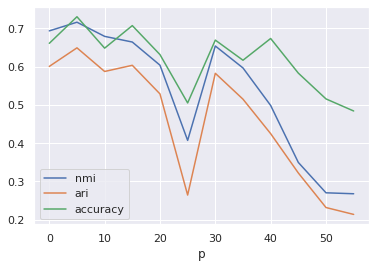

In [72]:
df_scores.plot(x='p',y=['nmi','ari','accuracy'])

### CoclustInfo avec initialisation des données manquantes avec IterativeImpute

In [0]:
# -*- coding: utf-8 -*-

"""
The :mod:`coclust.coclustering.coclust_info` module provides an implementation
of a co-clustering algorithm by an information-theoretic approach.
"""

# Author: Francois Role <francois.role@gmail.com>
#         Stanislas Morbieu <stanislas.morbieu@gmail.com>

# License: BSD 3 clause

import numpy as np
import scipy.sparse as sp
from scipy.sparse.sputils import isdense
from sklearn.utils import check_random_state, check_array

class CoclustInfo(BaseNonDiagonalCoclust):
    """Information-Theoretic Co-clustering.

    Parameters
    ----------
    n_row_clusters : int, optional, default: 2
        Number of row clusters to form

    n_col_clusters : int, optional, default: 2
        Number of column clusters to form

    init : numpy array or scipy sparse matrix, \
        shape (n_features, n_clusters), optional, default: None
        Initial column labels

    max_iter : int, optional, default: 20
        Maximum number of iterations

    n_init : int, optional, default: 1
        Number of time the algorithm will be run with different
        initializations. The final results will be the best output of `n_init`
        consecutive runs.

    random_state : integer or numpy.RandomState, optional
        The generator used to initialize the centers. If an integer is
        given, it fixes the seed. Defaults to the global numpy random
        number generator.

    tol : float, default: 1e-9
        Relative tolerance with regards to criterion to declare convergence

    Attributes
    ----------
    row_labels_ : array-like, shape (n_rows,)
        Bicluster label of each row

    column_labels_ : array-like, shape (n_cols,)
        Bicluster label of each column

    delta_kl_ : array-like, shape (k,l)
        Value :math:`\\frac{p_{kl}}{p_{k.} \\times p_{.l}}` for each row
        cluster k and column cluster l
    """

    def __init__(self, n_row_clusters=2, n_col_clusters=2, init=None,
                 max_iter=20, n_init=1, tol=1e-9, random_state=None):
        self.n_row_clusters = n_row_clusters
        self.n_col_clusters = n_col_clusters
        self.init = init
        self.max_iter = max_iter
        self.n_init = n_init
        self.tol = tol
        self.random_state = random_state

        self.row_labels_ = None
        self.column_labels_ = None
        self.criterions = []
        self.criterion = -np.inf
        self.delta_kl_ = None

    def fit(self, X, y=None):
        """Perform co-clustering.

        Parameters
        ----------
        X : numpy array or scipy sparse matrix, shape=(n_samples, n_features)
            Matrix to be analyzed
        """
        random_state = check_random_state(self.random_state)
        imp = IterativeImputer(missing_values=np.nan, sample_posterior=False, 
                                 max_iter=10, tol=0.001, 
                                 n_nearest_features=4, initial_strategy='mean',min_value=0,max_value=100)
        imp.fit(X)
        X=imp.transform(X)
        check_array(X, accept_sparse=True, dtype="numeric", order=None,
                    copy=False, force_all_finite=True, ensure_2d=True,
                    allow_nd=False, ensure_min_samples=self.n_row_clusters,
                    ensure_min_features=self.n_col_clusters,
                    warn_on_dtype=False, estimator=None)
        
        global indices 
        indices=np.argwhere(np.isnan(X))
        X=np.nan_to_num(X)  
        check_positive(X)

        X = X.astype(float)

        criterion = self.criterion
        criterions = self.criterions
        row_labels_ = self.row_labels_
        column_labels_ = self.column_labels_
        delta_kl_ = self.delta_kl_

        seeds = random_state.randint(np.iinfo(np.int32).max, size=self.n_init)
        for seed in seeds:
            self._fit_single(X, seed, y)
            if np.isnan(self.criterion):
                raise ValueError("matrix may contain negative or "
                                 "unexpected NaN values")
            # remember attributes corresponding to the best criterion
            if (self.criterion > criterion):
                criterion = self.criterion
                criterions = self.criterions
                row_labels_ = self.row_labels_
                column_labels_ = self.column_labels_
                delta_kl_ = self.delta_kl_

        # update attributes
        self.criterion = criterion
        self.criterions = criterions
        self.row_labels_ = row_labels_
        self.column_labels_ = column_labels_
        self.delta_kl_ = delta_kl_

        return self

    def _fit_single(self, X, random_state, y=None):
        """Perform one run of co-clustering.

        Parameters
        ----------
        X : numpy array or scipy sparse matrix, shape=(n_samples, n_features)
            Matrix to be analyzed
        """

        K = self.n_row_clusters
        L = self.n_col_clusters
        
        
        if self.init is None:
            W = random_init(L, X.shape[1], random_state)
        else:
            W = np.matrix(self.init, dtype=float)

        X = sp.csr_matrix(X)

        N = float(X.sum())
        X = X.multiply(1. / N)

        Z = sp.lil_matrix(random_init(K, X.shape[0], self.random_state))

        W = sp.csr_matrix(W)

        # Initial delta
        p_il = X * W
        # p_il = p_il     # matrix i,l ; column l' contains the p_il'
        p_kj = X.T * Z  # matrix j,k

        p_kd = p_kj.sum(axis=0)  # array containing the p_k.
        p_dl = p_il.sum(axis=0)  # array containing the p_.l

        # p_k. p_.l ; transpose because p_kd is "horizontal"
        p_kd_times_p_dl = p_kd.T * p_dl
        min_p_kd_times_p_dl = np.nanmin(
            p_kd_times_p_dl[
                np.nonzero(p_kd_times_p_dl)])
        p_kd_times_p_dl[p_kd_times_p_dl == 0.] = min_p_kd_times_p_dl * 0.01
        p_kd_times_p_dl_inv = 1. / p_kd_times_p_dl

        p_kl = (Z.T * X) * W
        delta_kl = p_kl.multiply(p_kd_times_p_dl_inv)

        change = True
        news = []

        n_iters = self.max_iter
        pkl_mi_previous = float(-np.inf)

        # Loop
        while change and n_iters > 0:
            change = False

            # Update Z
            p_il = X * W  # CSR matrix i,l 
            if not isdense(delta_kl):
                delta_kl = delta_kl.todense()
            delta_kl[delta_kl == 0.] = 0.0001  # to prevent log(0)
            log_delta_kl = np.log(delta_kl.T)
            log_delta_kl = sp.csr_matrix(log_delta_kl)

            # p_il matmul (log d_kl)T ; we examine each cluster
            Z1 = p_il @ log_delta_kl
            # Z1 is CSR which is bad for support item assignment. So convert Z1
            Z1 = Z1.toarray()
            Z = np.zeros_like(Z1)
            # Z[(line index 1...), (max col index for 1...)]
            Z[np.arange(len(Z1)), Z1.argmax(1)] = 1
            Z = sp.csr_matrix(Z)

            # Update delta
            # matrice d, k ; column k' contains the p_jk'
            p_kj = X.T * Z
            # p_il unchanged so no need for p_dl = p_il.sum(axis=0) 
            p_kd = p_kj.sum(axis=0)  # array k containing the p_k.

            # p_k. p_.l ; transpose because p_kd is "horizontal"
            p_kd_times_p_dl = p_kd.T * p_dl
            min_p_kd_times_p_dl = np.nanmin(
                p_kd_times_p_dl[
                    np.nonzero(p_kd_times_p_dl)])
            p_kd_times_p_dl[p_kd_times_p_dl == 0.] = min_p_kd_times_p_dl * 0.01
            p_kd_times_p_dl_inv = 1. / p_kd_times_p_dl
            p_kl = (Z.T * X) * W
            delta_kl = p_kl.multiply(p_kd_times_p_dl_inv)
            for ele in indices:
              k=np.argwhere(Z.todense()[ele[0]]==1)[0][1]
              l=np.argwhere(W.todense()[ele[1]]==1)[0][1]
              del_den=delta_kl.todense()
              X=X.todense()
              X[ele[0],ele[1]]=del_den[k,l]
              #print(test[k,l])
              X=sp.csr_matrix(X)

            # Update W
            p_kj = X.T * Z  # CSR matrice j,k
            if not isdense(delta_kl): # delta_kl should be a sparse coo here
                delta_kl = delta_kl.todense()
            delta_kl[delta_kl == 0.] = 0.0001  # to prevent log(0)
            log_delta_kl = np.log(delta_kl)
            log_delta_kl = sp.lil_matrix(log_delta_kl)
            W1 = p_kj * log_delta_kl  # p_kj * d_kl ; we examine each cluster
            # W1 is CSR which is bad for support item assignment. So convert W1
            W1 = W1.toarray()
            W = np.zeros_like(W1)
            W[np.arange(len(W1)), W1.argmax(1)] = 1
            W = sp.csr_matrix(W)

            # Update delta
            p_il = X * W     # matrix d,k ; column k' contains the p_jk'
            # p_kj unchanged so no need for p_kd = p_kj.sum(axis=0) 
            p_dl = p_il.sum(axis=0)  # array l containing the p_.l
            

            # p_k. p_.l ; transpose because p_kd is "horizontal"
            p_kd_times_p_dl = p_kd.T * p_dl
            min_p_kd_times_p_dl = np.nanmin(
                p_kd_times_p_dl[
                    np.nonzero(p_kd_times_p_dl)])
            p_kd_times_p_dl[p_kd_times_p_dl == 0.] = min_p_kd_times_p_dl * 0.01
            p_kd_times_p_dl_inv = 1. / p_kd_times_p_dl
            p_kl = (Z.T * X) * W

            delta_kl = p_kl.multiply(p_kd_times_p_dl_inv)
            # to prevent log(0) when computing criterion
            # but note that delta_kl = csr eletwise-mult array is a coo
            # which does not support item assignment

            if not isdense(delta_kl):
                delta_kl = delta_kl.todense()
            delta_kl[delta_kl == 0.] = 0.0001

            # Criterion
            # p_kl is csr_matrix; delta_kl is np.matrix
            # just in case, note that their matmul results in a COO matrix !
            pkl_mi = p_kl.multiply(np.log(delta_kl) )
            pkl_mi = pkl_mi.sum()

            if np.abs(pkl_mi - pkl_mi_previous) > self.tol:
                pkl_mi_previous = pkl_mi
                change = True
                news.append(pkl_mi)
                n_iters -= 1
            for ele in indices:
              k=np.argwhere(Z.todense()[ele[0]]==1)[0][1]
              l=np.argwhere(W.todense()[ele[1]]==1)[0][1]
              del_den=delta_kl.todense()
              X=X.todense()
              X[ele[0],ele[1]]=del_den[k,l]
              #print(test[k,l])
              X=sp.csr_matrix(X)

        self.criterions = news
        self.criterion = pkl_mi
        self.row_labels_ = Z.toarray().argmax(axis=1).tolist()
        self.column_labels_ = W.toarray().argmax(axis=1).tolist()
        self.delta_kl_ = delta_kl
        self.Z = Z
        self.W = W

### Coclust Avec initialisation en zéro des données manquantes

In [0]:
# -*- coding: utf-8 -*-

"""
The :mod:`coclust.coclustering.coclust_info` module provides an implementation
of a co-clustering algorithm by an information-theoretic approach.
"""

# Author: Francois Role <francois.role@gmail.com>
#         Stanislas Morbieu <stanislas.morbieu@gmail.com>

# License: BSD 3 clause

import numpy as np
import scipy.sparse as sp
from scipy.sparse.sputils import isdense
from sklearn.utils import check_random_state, check_array

class CoclustInfo(BaseNonDiagonalCoclust):
    """Information-Theoretic Co-clustering.

    Parameters
    ----------
    n_row_clusters : int, optional, default: 2
        Number of row clusters to form

    n_col_clusters : int, optional, default: 2
        Number of column clusters to form

    init : numpy array or scipy sparse matrix, \
        shape (n_features, n_clusters), optional, default: None
        Initial column labels

    max_iter : int, optional, default: 20
        Maximum number of iterations

    n_init : int, optional, default: 1
        Number of time the algorithm will be run with different
        initializations. The final results will be the best output of `n_init`
        consecutive runs.

    random_state : integer or numpy.RandomState, optional
        The generator used to initialize the centers. If an integer is
        given, it fixes the seed. Defaults to the global numpy random
        number generator.

    tol : float, default: 1e-9
        Relative tolerance with regards to criterion to declare convergence

    Attributes
    ----------
    row_labels_ : array-like, shape (n_rows,)
        Bicluster label of each row

    column_labels_ : array-like, shape (n_cols,)
        Bicluster label of each column

    delta_kl_ : array-like, shape (k,l)
        Value :math:`\\frac{p_{kl}}{p_{k.} \\times p_{.l}}` for each row
        cluster k and column cluster l
    """

    def __init__(self, n_row_clusters=2, n_col_clusters=2, init=None,
                 max_iter=20, n_init=1, tol=1e-9, random_state=None):
        self.n_row_clusters = n_row_clusters
        self.n_col_clusters = n_col_clusters
        self.init = init
        self.max_iter = max_iter
        self.n_init = n_init
        self.tol = tol
        self.random_state = random_state

        self.row_labels_ = None
        self.column_labels_ = None
        self.criterions = []
        self.criterion = -np.inf
        self.delta_kl_ = None

    def fit(self, X, y=None):
        """Perform co-clustering.

        Parameters
        ----------
        X : numpy array or scipy sparse matrix, shape=(n_samples, n_features)
            Matrix to be analyzed
        """
        random_state = check_random_state(self.random_state)
        X=np.nan_to_num(X) 
        check_array(X, accept_sparse=True, dtype="numeric", order=None,
                    copy=False, force_all_finite=True, ensure_2d=True,
                    allow_nd=False, ensure_min_samples=self.n_row_clusters,
                    ensure_min_features=self.n_col_clusters,
                    warn_on_dtype=False, estimator=None)
        
        global indices 
        indices=np.argwhere(np.isnan(X))
        X=np.nan_to_num(X)  
        check_positive(X)

        X = X.astype(float)

        criterion = self.criterion
        criterions = self.criterions
        row_labels_ = self.row_labels_
        column_labels_ = self.column_labels_
        delta_kl_ = self.delta_kl_

        seeds = random_state.randint(np.iinfo(np.int32).max, size=self.n_init)
        for seed in seeds:
            self._fit_single(X, seed, y)
            if np.isnan(self.criterion):
                raise ValueError("matrix may contain negative or "
                                 "unexpected NaN values")
            # remember attributes corresponding to the best criterion
            if (self.criterion > criterion):
                criterion = self.criterion
                criterions = self.criterions
                row_labels_ = self.row_labels_
                column_labels_ = self.column_labels_
                delta_kl_ = self.delta_kl_

        # update attributes
        self.criterion = criterion
        self.criterions = criterions
        self.row_labels_ = row_labels_
        self.column_labels_ = column_labels_
        self.delta_kl_ = delta_kl_

        return self

    def _fit_single(self, X, random_state, y=None):
        """Perform one run of co-clustering.

        Parameters
        ----------
        X : numpy array or scipy sparse matrix, shape=(n_samples, n_features)
            Matrix to be analyzed
        """

        K = self.n_row_clusters
        L = self.n_col_clusters
        
        
        if self.init is None:
            W = random_init(L, X.shape[1], random_state)
        else:
            W = np.matrix(self.init, dtype=float)

        X = sp.csr_matrix(X)

        N = float(X.sum())
        X = X.multiply(1. / N)

        Z = sp.lil_matrix(random_init(K, X.shape[0], self.random_state))

        W = sp.csr_matrix(W)

        # Initial delta
        p_il = X * W
        # p_il = p_il     # matrix i,l ; column l' contains the p_il'
        p_kj = X.T * Z  # matrix j,k

        p_kd = p_kj.sum(axis=0)  # array containing the p_k.
        p_dl = p_il.sum(axis=0)  # array containing the p_.l

        # p_k. p_.l ; transpose because p_kd is "horizontal"
        p_kd_times_p_dl = p_kd.T * p_dl
        min_p_kd_times_p_dl = np.nanmin(
            p_kd_times_p_dl[
                np.nonzero(p_kd_times_p_dl)])
        p_kd_times_p_dl[p_kd_times_p_dl == 0.] = min_p_kd_times_p_dl * 0.01
        p_kd_times_p_dl_inv = 1. / p_kd_times_p_dl

        p_kl = (Z.T * X) * W
        delta_kl = p_kl.multiply(p_kd_times_p_dl_inv)

        change = True
        news = []

        n_iters = self.max_iter
        pkl_mi_previous = float(-np.inf)

        # Loop
        while change and n_iters > 0:
            change = False

            # Update Z
            p_il = X * W  # CSR matrix i,l 
            if not isdense(delta_kl):
                delta_kl = delta_kl.todense()
            delta_kl[delta_kl == 0.] = 0.0001  # to prevent log(0)
            log_delta_kl = np.log(delta_kl.T)
            log_delta_kl = sp.csr_matrix(log_delta_kl)

            # p_il matmul (log d_kl)T ; we examine each cluster
            Z1 = p_il @ log_delta_kl
            # Z1 is CSR which is bad for support item assignment. So convert Z1
            Z1 = Z1.toarray()
            Z = np.zeros_like(Z1)
            # Z[(line index 1...), (max col index for 1...)]
            Z[np.arange(len(Z1)), Z1.argmax(1)] = 1
            Z = sp.csr_matrix(Z)

            # Update delta
            # matrice d, k ; column k' contains the p_jk'
            p_kj = X.T * Z
            # p_il unchanged so no need for p_dl = p_il.sum(axis=0) 
            p_kd = p_kj.sum(axis=0)  # array k containing the p_k.

            # p_k. p_.l ; transpose because p_kd is "horizontal"
            p_kd_times_p_dl = p_kd.T * p_dl
            min_p_kd_times_p_dl = np.nanmin(
                p_kd_times_p_dl[
                    np.nonzero(p_kd_times_p_dl)])
            p_kd_times_p_dl[p_kd_times_p_dl == 0.] = min_p_kd_times_p_dl * 0.01
            p_kd_times_p_dl_inv = 1. / p_kd_times_p_dl
            p_kl = (Z.T * X) * W
            delta_kl = p_kl.multiply(p_kd_times_p_dl_inv)
            for ele in indices:
              k=np.argwhere(Z.todense()[ele[0]]==1)[0][1]
              l=np.argwhere(W.todense()[ele[1]]==1)[0][1]
              del_den=delta_kl.todense()
              X=X.todense()
              X[ele[0],ele[1]]=del_den[k,l]
              #print(test[k,l])
              X=sp.csr_matrix(X)

            # Update W
            p_kj = X.T * Z  # CSR matrice j,k
            if not isdense(delta_kl): # delta_kl should be a sparse coo here
                delta_kl = delta_kl.todense()
            delta_kl[delta_kl == 0.] = 0.0001  # to prevent log(0)
            log_delta_kl = np.log(delta_kl)
            log_delta_kl = sp.lil_matrix(log_delta_kl)
            W1 = p_kj * log_delta_kl  # p_kj * d_kl ; we examine each cluster
            # W1 is CSR which is bad for support item assignment. So convert W1
            W1 = W1.toarray()
            W = np.zeros_like(W1)
            W[np.arange(len(W1)), W1.argmax(1)] = 1
            W = sp.csr_matrix(W)

            # Update delta
            p_il = X * W     # matrix d,k ; column k' contains the p_jk'
            # p_kj unchanged so no need for p_kd = p_kj.sum(axis=0) 
            p_dl = p_il.sum(axis=0)  # array l containing the p_.l
            

            # p_k. p_.l ; transpose because p_kd is "horizontal"
            p_kd_times_p_dl = p_kd.T * p_dl
            min_p_kd_times_p_dl = np.nanmin(
                p_kd_times_p_dl[
                    np.nonzero(p_kd_times_p_dl)])
            p_kd_times_p_dl[p_kd_times_p_dl == 0.] = min_p_kd_times_p_dl * 0.01
            p_kd_times_p_dl_inv = 1. / p_kd_times_p_dl
            p_kl = (Z.T * X) * W

            delta_kl = p_kl.multiply(p_kd_times_p_dl_inv)
            # to prevent log(0) when computing criterion
            # but note that delta_kl = csr eletwise-mult array is a coo
            # which does not support item assignment

            if not isdense(delta_kl):
                delta_kl = delta_kl.todense()
            delta_kl[delta_kl == 0.] = 0.0001

            # Criterion
            # p_kl is csr_matrix; delta_kl is np.matrix
            # just in case, note that their matmul results in a COO matrix !
            pkl_mi = p_kl.multiply(np.log(delta_kl) )
            pkl_mi = pkl_mi.sum()

            if np.abs(pkl_mi - pkl_mi_previous) > self.tol:
                pkl_mi_previous = pkl_mi
                change = True
                news.append(pkl_mi)
                n_iters -= 1
            for ele in indices:
              k=np.argwhere(Z.todense()[ele[0]]==1)[0][1]
              l=np.argwhere(W.todense()[ele[1]]==1)[0][1]
              del_den=delta_kl.todense()
              X=X.todense()
              X[ele[0],ele[1]]=del_den[k,l]
              #print(test[k,l])
              X=sp.csr_matrix(X)

        self.criterions = news
        self.criterion = pkl_mi
        self.row_labels_ = Z.toarray().argmax(axis=1).tolist()
        self.column_labels_ = W.toarray().argmax(axis=1).tolist()
        self.delta_kl_ = delta_kl
        self.Z = Z
        self.W = W